In [1]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from typing import List, Dict
from collections import Counter
from seaborn import heatmap

# preprocess data

In [2]:
x = pd.read_csv('../data/NER_dataset/ner_dataset.csv',encoding='latin-1')

In [ ]:
x['Sentence #'] = x['Sentence #'].fillna(method='ffill')

In [ ]:
# this is seriously important, which can save you hours
x = x.set_index('Sentence #')

In [ ]:
# best groupby speedup for now
new_df = x.groupby(level=(0)).apply(lambda x: [x['Word'].str.cat(sep=' '), x['Tag'].str.cat(sep=' ')])

In [ ]:
# this can be improved
new_df = pd.DataFrame([d for d in new_df],columns=['Text','Label'])

In [ ]:
new_df.to_csv('train.csv',index=False)

# load text data

In [3]:
def iter_func(dataset: pd.DataFrame, x_or_y: str) -> List[str]:
    
    for text, label in dataset:
        if x_or_y == 'x':
            yield tokenizer(text)
        elif x_or_y == 'y':
            yield tokenizer(label)

In [4]:
# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat([torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])])

In [5]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

In [6]:
# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample))
        tgt_batch.append(label_transform(tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [7]:
class NERDataset(Dataset):

    def __init__(self, data, x_transform=None, y_transform=None):
        self.data = data
        self.transform = (x_transform,y_transform)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        text, label = self.data[idx]
        
        if self.transform[0] and self.transform[1]:
            x, y = self.transform
            text = x(text)
            label = y(label)
        
        return text, label

In [8]:
training_data = pd.read_csv('../data/NER_dataset/train.csv').dropna().to_numpy().tolist()

In [9]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

In [10]:
tokenizer = get_tokenizer(lambda a: a.split(' '))

In [11]:
text_vocab = build_vocab_from_iterator(iter_func(training_data,'x'), 
                                            specials=special_tokens,
                                            special_first=True)
    
text_vocab.set_default_index(UNK_IDX)

In [12]:
label_vocab = build_vocab_from_iterator(iter_func(training_data,'y'), 
                                            specials=special_tokens,
                                            special_first=True)
    
label_vocab.set_default_index(UNK_IDX)

In [13]:
# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(tokenizer, text_vocab, tensor_transform)
label_transform = sequential_transforms(tokenizer, label_vocab, tensor_transform)

# utils

In [74]:
def viterbi_decode(yhat, transition_matrix, mask=None):
    """
    forward backward algorithm
    
    viterbi forward: path score
    backward: find token
    
    """
    seq_len, batch_size, label_size = yhat.size()

    backpointers = []

    # forward
    init_vvars = torch.full((batch_size, label_size), LIKELIHOOD_INIT)
    init_vvars[:,BOS_IDX] = 0
    
    for s, feat in enumerate(yhat):
        # batch_size, next_tag, current_tag
        viterai_t = init_vvars.unsqueeze(1) +transition_matrix.unsqueeze(0) # B,1,L + 1,L,L 
        viterai_t, bkptr_t = torch.max(viterai_t, -1) # B,L
        viterai_t += feat #B,L
        backpointers.append(bkptr_t) #S x B,L
        
        if mask is not None:
            mask_t = mask[s].unsqueeze(-1)  # B, 1
        else:
            mask_t = torch.ones(batch_size,1).to(device)
        
        init_vvars = viterai_t * mask_t.long() + init_vvars * (1 - mask_t.long()) #B,L
        
    backpointers = torch.stack(backpointers, 0) # S, B, L
    init_vvars += transition_matrix[EOS_IDX].unsqueeze(0) # 1, L
    best_score, best_tag = torch.max(init_vvars, -1)  # B
    
    # backtracking
    best_path = best_tag.unsqueeze(-1).tolist() # B,1
    for i in range(batch_size):
        best_tag_i = best_tag[i] # 1
        seq_len_i = int(mask[:, i].sum()) if mask is not None else len(yhat)
        for ptr_t in reversed(backpointers[:seq_len_i, i]): # S, L
            best_tag_i = ptr_t[best_tag_i].item() # S+1 x L
            best_path[i].append(best_tag_i)
        # pop first tag
        best_path[i].pop() #B,S,L
        # reverse order
        best_path[i].reverse()
    
    return best_score, best_path # B # B,S,L

# model

In [15]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size:int, label_num:int, embedding_dim:int, hidden_dim:int):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = label_num

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        self.ln = nn.LayerNorm(hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        
        # transition matrix
        # store not prob but log likelihood 
        # from j to i !?
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size).to(device))
        # never transfer to the start tag
        self.transitions.data[BOS_IDX, :] = LIKELIHOOD_INIT
        # never transfer from the start to the end
        self.transitions.data[EOS_IDX, BOS_IDX] = LIKELIHOOD_INIT
        # never transfer from the eos
        self.transitions.data[:, EOS_IDX] = LIKELIHOOD_INIT
        

    def get_token_output(self, sentences):
        """token classfication"""
        mask = sentences.ne(PAD_IDX)
        mask_length, mask_order = mask.sum(0).sort(descending=True)
        embeds = self.word_embeds(sentences)[:,mask_order,:]
        embeds = pack_padded_sequence(embeds, mask_length)
        lstm_out, _ = self.lstm(embeds)
        lstm_out, _ = pad_packed_sequence(lstm_out) # S, B, H
        lstm_out = self.ln(lstm_out * mask.unsqueeze(-1))
        lstm_feats = self.hidden2tag(lstm_out * mask.unsqueeze(-1)) * mask.unsqueeze(-1) # S, B, L
        _, sort_back = mask_order.sort()
        lstm_feats = lstm_feats[:,sort_back,:]
        return lstm_feats
    
    def forward(self, sentence):

        lstm_feats = self.get_token_output(sentence)
        
        return lstm_feats

In [16]:
class customloss(nn.Module):
    
    def __init__(self, label_num: int):
        super(customloss,self).__init__()
        self.target_size = label_num
        
    # Compute log sum exp in a numerically stable way for the forward algorithm
    @staticmethod
    def log_sum_exp(x):
        """log softmax"""
        max_score, _ = x.max(-1, keepdim=True) # B, L, 1
        return max_score + torch.exp(x - max_score).sum(-1, keepdim=True).log()
        
    def forward_alg(self, yhat, mask, transition_matrix):
        """yhat on its own"""
        
        seq_len, batch_size, _ = yhat.shape
        
        # batch_size, label_size
        alpha = torch.full((batch_size, self.target_size), LIKELIHOOD_INIT).to(device)
        # BOS has all of the score.
        alpha[:, BOS_IDX] = 0

        # batch_size, next_tag, current_tag
        for s, feat in enumerate(yhat):
            
            emit_score = feat.unsqueeze(-1) # B, L, 1
            transition_score = transition_matrix.unsqueeze(0) # 1, L, L
            alpha_score = alpha.unsqueeze(1) # B, 1, L
            
            alpha_score = alpha_score + transition_score + emit_score #B,L,L
            mask_t = mask[s].unsqueeze(-1) # B,1
            alpha = self.log_sum_exp(alpha_score).squeeze(-1) * mask_t.long() + alpha * (1 - mask_t.long()) # B, L
                    
        alpha = alpha + transition_matrix[EOS_IDX].unsqueeze(0) # B,L + 1, L
        
        return self.log_sum_exp(alpha).squeeze(-1) # B
                
    def score_sentence(self, yhat, y, mask, transition_matrix):
        """yhat with true path"""
        
        assert y.size(0) == yhat.size(0), f'misaligned seq length {y.size(0)}, {yhat.size(0)}'
        assert y.size(1) == yhat.size(1), 'misaligned batch size'
        assert yhat.size(2) == len(label_vocab), 'wrong yhat label size'
        
        seq_len, batch_size = y.size()
        scores = torch.zeros(batch_size).to(device)
        start_tag = torch.full((1, batch_size), fill_value=BOS_IDX)
        y = torch.cat([start_tag,y],0) # S+1, B
        
        for s, feat in enumerate(yhat):
            emit_score = torch.stack([f[next_tag] for f, next_tag in zip(feat, y[s + 1])]) # B, L
            transition_score = torch.stack([transition_matrix[y[s + 1, b], y[s, b]] for b in range(batch_size)]) # B
            scores += (emit_score + transition_score) * mask[s] # B
        transition_to_end = torch.stack([transition_matrix[EOS_IDX, tag[mask[:, b].sum().long()]] for b, tag in enumerate(y.transpose(0, 1))])
        scores += transition_to_end
        
        return scores
    
        
    def forward(self, yhat, y, mask, transition_matrix):
                
        forward_score = self.forward_alg(yhat, mask, transition_matrix)
        
        gold_score = self.score_sentence(yhat, y, mask, transition_matrix)
                        
        return (forward_score - gold_score).sum()

# setting

In [22]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
EPOCHES = 10
BATCH_SIZE = 128
device = 'cpu'
LIKELIHOOD_INIT = -10000

In [23]:
trainset = NERDataset(training_data)

In [24]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [25]:
model = BiLSTM_CRF(len(text_vocab), len(label_vocab), EMBEDDING_DIM, HIDDEN_DIM).to(device)

In [26]:
criterion = customloss(len(label_vocab))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

# training

In [27]:
model.train()
for epoch in range(EPOCHES):
    running_loss = 0
    for datas in tqdm(trainloader):
        optimizer.zero_grad()
        
        sentence, tags = datas
        sentence = sentence.to(device)
        tags = tags.to(device)        
        
        output = model(sentence)
        
        loss = criterion(output, tags, sentence.ne(PAD_IDX), model.transitions)
        loss.backward()
        optimizer.step()
                
        running_loss += loss.item()
                            
    print(f'epoch {epoch+1}: {running_loss/len(training_data)}')

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 1: 12779.68973628516


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 2: 9992.40908249755


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 3: 9422.148295940282


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 4: 8173.158721512125


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 5: 6635.433308920119


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 6: 4478.236309920974


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 7: 3899.988939119873


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 8: 3622.9017070570694


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch 9: 3344.912685835818


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [03:37<00:00,  1.73it/s]

epoch 10: 3209.1510746809777


In [28]:
torch.save(model,'crf.pth')

In [20]:
model = torch.load('crf.pth')

# prediction

In [61]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(trainset):
        sentence, tag = data
        output = model(text_transform(sentence).unsqueeze(1))
        score, tag_seq = viterbi_decode(output,model.transitions)
        tag_seq = np.array(tag_seq).flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq)
        print('--------------',i)
        print('score: ', score.item())
        print('pred : ', *[f'{d:<5}' for d in decoded_seq[1:-1]])
        print('label: ', *[f'{t:<5}' for t in tag.split(' ')])
        print('text : ', sentence)
        print()
        if i>10: break

-------------- 0
score:  -2212.620849609375
pred :  O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     O    
label:  O     O     O     O     O     O     B-geo O     O     O     O     O     B-geo O     O     O     O     O     B-gpe O     O     O     O     O    
text :  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

-------------- 1
score:  -1754.36865234375
pred :  O     O     O     O     O     O     O     O     O     O     O     O     O     O     O     B-tim O     O     O     O     O     O     O     O     O    
label:  B-gpe O     O     O     O     O     O     O     O     O     O     O     O     O     O     B-tim O     O     O     B-org O     O     O     O     O    
text :  Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance syst

# Evaluation

In [98]:
model.eval()
acc = 0
with torch.no_grad():
    for i, data in enumerate(tqdm(trainloader)):
        sentence, tag = data
        mask = sentence.ne(PAD_IDX)
        output = model(sentence)
        score, tag_seq = viterbi_decode(output,model.transitions,mask=mask)
        for b in range(len(tag_seq)):
            tmp_yhat = torch.Tensor(tag_seq[b])
            tmp_y = tag[:tag[:,b].ne(PAD_IDX).sum(),b]
            assert tmp_yhat.size(0) == tmp_y.size(0), 'misaligned'
            acc += tmp_y[1:-1].eq(tmp_yhat[1:-1]).float().mean().item()

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:35<00:00, 10.46it/s]


In [99]:
acc/len(trainset)

0.8473807377815893

In [100]:
model.eval()
acc = torch.zeros(len(label_vocab)-len(special_tokens))
with torch.no_grad():
    for i, data in enumerate(tqdm(trainloader)):
        sentence, tag = data
        mask = sentence.ne(PAD_IDX)
        output = model(sentence)
        score, tag_seq = viterbi_decode(output,model.transitions,mask=mask)
        for b in range(len(tag_seq)):
            tmp_yhat = torch.Tensor(tag_seq[b])
            tmp_y = tag[:tag[:,b].ne(PAD_IDX).sum(),b]
            assert tmp_yhat.size(0) == tmp_y.size(0), 'misaligned'
            tmp_acc = tmp_y[1:-1].eq(tmp_yhat[1:-1]).float().div(len(tmp_y)-2)
            for a,b in zip(tmp_y[1:-1],tmp_acc): acc[a-len(special_tokens)] += b 

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:48<00:00,  7.66it/s]


In [114]:
for a,b in zip(label_vocab.get_itos()[len(special_tokens):],acc.div(len(trainset)).mul(1000).round().tolist()):
    print(f'acc {a:<5} : {b/10} %')

acc O     : 82.4 %
acc B-geo : 0.6 %
acc B-tim : 0.5 %
acc B-org : 0.1 %
acc I-per : 0.2 %
acc B-per : 0.5 %
acc I-org : 0.1 %
acc B-gpe : 0.2 %
acc I-geo : 0.1 %
acc I-tim : 0.0 %
acc B-art : 0.0 %
acc B-eve : 0.0 %
acc I-art : 0.0 %
acc I-eve : 0.0 %
acc B-nat : 0.0 %
acc I-gpe : 0.0 %
acc I-nat : 0.0 %


# Visualization

<AxesSubplot:>

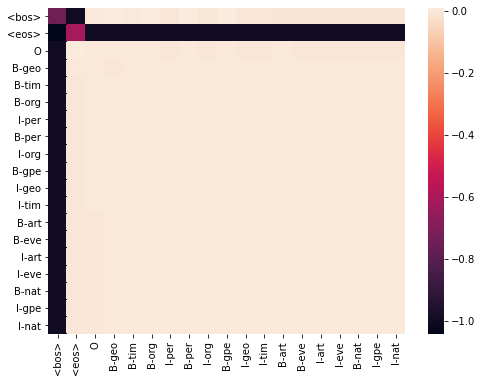

In [62]:
plt.figure(figsize=(8,6))
heatmap(model.transitions[2:,2:].div(-LIKELIHOOD_INIT).clone().detach().numpy().transpose(),
        xticklabels=label_vocab.get_itos()[2:],      
        yticklabels=label_vocab.get_itos()[2:])